# HNCDI Explain Quantum Training

In [1]:
# Default imports
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.compiler import transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
# Notebook imports
from qiskit.providers.ibmq import least_busy

# pi approximation
from qiskit import assemble
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt

In [3]:
# Version Information
%qiskit_version_table

## Create your Bell state circuit

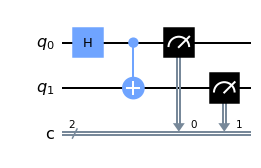

In [4]:
# Create your Bell state circuit

qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')

circuit = QuantumCircuit(qreg_q, creg_c)

circuit.h(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])

circuit.draw()

## Submit Bell state circuit to a simulator

In [5]:
# View backends
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [6]:
# Set simulator backend
simulator_backend = Aer.get_backend('aer_simulator')

In [7]:
# Submit job to simulator backend
simulator_job = simulator_backend.run(circuit, shots=1024)

In [8]:
# List measurement outcomes
simulator_job_counts = simulator_job.result().get_counts()
simulator_job_counts

{'00': 529, '11': 495}

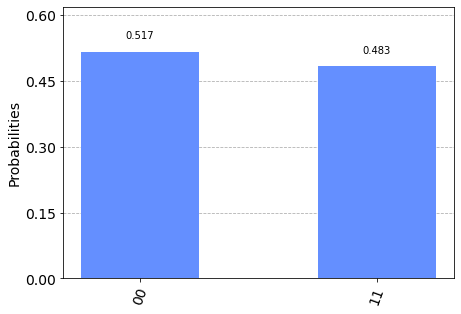

In [9]:
# Plot measurement outcomes 
plot_histogram(simulator_job_counts)

## Submit your Bell state circuit to real quantum hardware

In [10]:
# View backends
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [11]:
# Visual overview of available machines

%qiskit_backend_overview

In [12]:
# Find least busy machine to submit a job to. Set IBMQ backend to this machine.

ibmq_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                            and not x.configuration().simulator 
                                            and x.status().operational==True))                
ibmq_backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

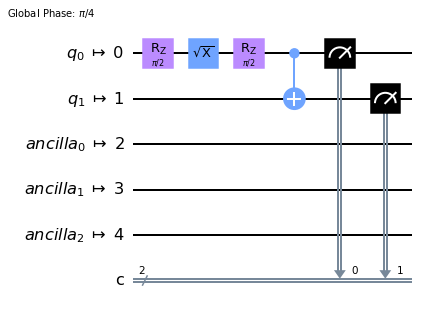

In [13]:
# Transpile your circuit for the IBMQ backend
transpiled_circuit = transpile(circuit, ibmq_backend)
transpiled_circuit.draw()

In [14]:
# Submit job to IBMQ backend
ibmq_job = ibmq_backend.run(transpiled_circuit, shots=1024)

In [15]:
# List measurement outcomes
ibmq_job_counts = ibmq_job.result().get_counts()
ibmq_job_counts

{'00': 518, '01': 31, '10': 19, '11': 456}

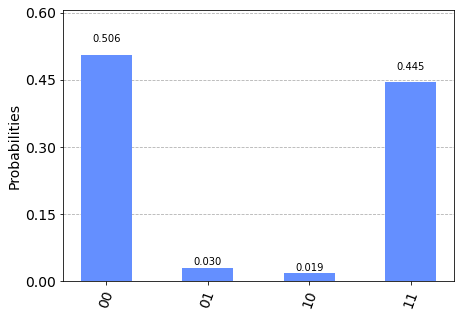

In [16]:
# Plot measurement outcomes
plot_histogram(ibmq_job_counts)

## Approximating $\pi$ using IBMQ

In [17]:
#Compute the Inverse Quantum Fourier Transform

def qft_dagger(circ_, n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    for qubit in range(int(n_qubits/2)):
        circ_.swap(qubit, n_qubits-qubit-1)
    for j in range(0,n_qubits):
        for m in range(j):
            circ_.cp(-np.pi/float(2**(j-m)), m, j)
        circ_.h(j)

In [18]:
#Initial state of Quantum Phase Estimation

def qpe_pre(circ_, n_qubits):
    circ_.h(range(n_qubits))
    circ_.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ_.cp(1, n_qubits-1-x, n_qubits)

In [19]:
def run_job(circ, backend, shots, optimization_level=0):
    t_circ = transpile(circ, backend, optimization_level=optimization_level)
    qobj = assemble(t_circ, shots=shots)
    job = backend.run(qobj)
    job_monitor(job)
    return job.result().get_counts()

In [20]:
def get_pi_estimate(n_qubits, backend, shots):
        
    # create the circuit
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    
    # create the input state
    qpe_pre(circ, n_qubits)
        
    # apply a barrier
    circ.barrier()
    # apply the inverse fourier transform
    qft_dagger(circ, n_qubits)
    # apply  a barrier
    circ.barrier()
    # measure all but the last qubits
    circ.measure(range(n_qubits), range(n_qubits))
    
    # optionally save to a file
    if n_qubits == 3:
        circ.draw(filename='qpe')

    # run the job and get the results
    counts = run_job(circ, backend, shots, optimization_level=0)
    print('counts = ', counts) 

    # get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    print('max_counts_result = ', max_counts_result)
    max_counts_result = int(max_counts_result, 2)
    print('max_counts_result = ', max_counts_result)
    
    # solve for pi from the measured counts
    theta = max_counts_result/2**n_qubits
    return (1./(2*theta))

In [21]:
# estimate pi using different numbers of qubits

shots = 10000
nqs = list(range(2,12+1))
pi_estimates = []
for nq in nqs:
    thisnq_pi_estimate = get_pi_estimate(nq, simulator_backend, shots)
    pi_estimates.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

Job Status: job has successfully run
counts =  {'11': 559, '01': 6569, '10': 657, '00': 2215}
max_counts_result =  01
max_counts_result =  1
2 qubits, pi ≈ 2.0
Job Status: job has successfully run
counts =  {'010': 1129, '100': 110, '110': 101, '001': 7782, '101': 93, '011': 248, '000': 408, '111': 129}
max_counts_result =  001
max_counts_result =  1
3 qubits, pi ≈ 4.0
Job Status: job has successfully run
counts =  {'1101': 57, '1010': 33, '1111': 92, '1110': 65, '1011': 39, '1000': 56, '0000': 176, '0111': 67, '0011': 4798, '0010': 3330, '1100': 33, '0101': 206, '0001': 445, '1001': 38, '0110': 110, '0100': 455}
max_counts_result =  0011
max_counts_result =  3
4 qubits, pi ≈ 2.6666666666666665
Job Status: job has successfully run
counts =  {'01110': 1, '10010': 1, '10101': 1, '11010': 1, '01111': 2, '10111': 1, '11100': 2, '01101': 2, '00001': 3, '01001': 6, '00101': 9707, '01100': 3, '00010': 12, '00110': 115, '00111': 25, '00100': 75, '00011': 13, '11011': 2, '01000': 10, '00000': 6

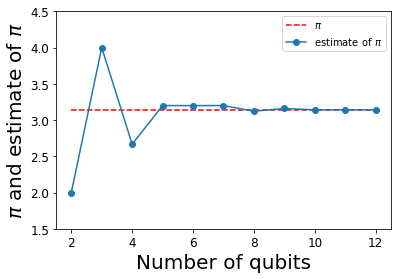

In [22]:
pi = np.pi

plt.plot(nqs, [pi]*len(nqs), '--r')
plt.plot(nqs, pi_estimates, '.-', markersize=12)
plt.xlim([1.5, 12.5])
plt.ylim([1.5, 4.5])
plt.legend(['$\pi$', 'estimate of $\pi$'])
plt.xlabel('Number of qubits', fontdict={'size':20})
plt.ylabel('$\pi$ and estimate of $\pi$', fontdict={'size':20})
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()